# Submission 3: Algorithmic Trading Strategy

For this submission, you will extend ARMA to model non-linear patterns, which are often encountered in financial time series data. Basic forms of neural networks are implemented to obtain short-term predictions that can be used as trading signals in algorithmic trading strategies.
Developing an Algorithmic Trading Strategy
### Design your own algorithmic trading strategy, with the following characteristics:
- Number of assets in the strategy: One or more assets
- Type of asset: Select the type of asset that you prefer: stock, commodity, FX,c ryptoetc) 
- Time frame: Your choice
- Coding language: R or Python. You can use Excel for basic calculations and testing
- Model: regression, ARMA, GARCH, VAR, VEC or any other quantitative model you know. You can combine the selected model with technical analysis indicators (MA, MACD, Bollinger bands, etc.) as shown in the examples provided in the course. You may also use a machine learning algorithm (optional).
## Writing Your Report
Write a well-structured formal report on the algorithmic trading strategy that you have developed with introduction, comments, code, and conclusion sections. The report must include the following sections:
- Introduction
- Description of the trading strategy that you have developed, step by step
- The R or Python code that you have developed including clear comments
- Excel calculations (if used): include screenshots of your calculations and the used parameters
- Calculation of returns,cumulative returns,standard deviation,and forecasts
- The results of your analysis and the obtained charts
- Possible ways for improving the algorithmic trading strategy that you have developed 
- Conclusions, and References
### Submission Requirements
Required length for your report: 3 pages or about 1,500 words. 

Submit your report in a PDF document.

Submit your source code separately. Add appropriate comments to explain how it works.

## Trading Strategy with a combination of ARIMA and GARCH

We will use a rolling window algorithm based on ARIMA and GARCH for the AAPL Stock from January 2017 to December 2019. 
1. Rolling window is taken to be 500 past days differenced log return. 
2. Each day forward we will fit ARIMA and GARCH model like our previous submission. And forcast the return. 
3. If the return is positive, then its a **BUY SIGNAL**
4. If its negative then its a "**SHORT SIGNAL**
5. If the return unchanged then its a **HOLD SIGNAL**

#### Module Imports
We would import the basic libraries to analyse and visualise our trading strategy. 

In [2]:
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from arch import arch_model
import statsmodels.tsa.api as smt

In [3]:
%config Completer.use_jedi = False

In [4]:
sns.set(rc={'figure.figsize':(10,7)})

In [5]:
warnings.filterwarnings("ignore")

#### Data Processing
With the pandas datareader library, we would download the adjusted closing price of the "AAPL" (Apple Inc) stock from the yahoo finance. Put it in a dataframe. We would then take the log prices of the stock and difference the series. The data is now stationary and ready for forecasting. 

In [6]:
# Getting the data from yahoo
df = pdr.DataReader('AAPL', data_source='yahoo', start='2017-01-01', end='2019-12-30')['Adj Close']

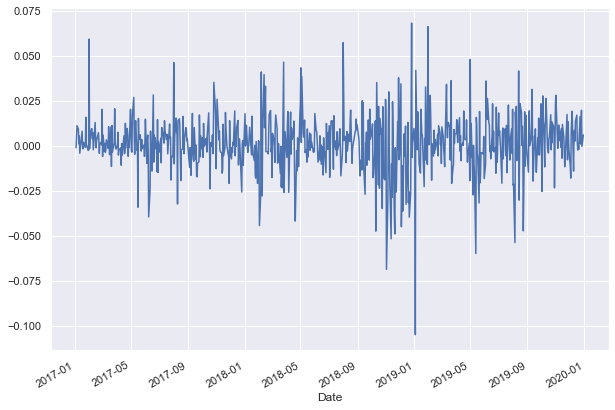

In [7]:
# log price and log differenced series
dflr = np.log(df)
dflr = dflr.diff(1).dropna()
dflr.plot()

In [52]:
# Standard Deviation of the log differenced series
print("Standard Deviation of the dataset: " + str(round(dflr.std()*np.sqrt(251), 2)))

Standard Deviation of the dataset: 0.25


#### ARIMA + GARCH
Now we would try to fit the timeseries to a ARIMA model. For the necessary order of (p,d,q) we would try out various number of p, d, q for the data, and take the lowest AIC valued model as the best fitted ARIMA model for each dataset. 

In [11]:

def best_fit_model(ts):
    best_aic = np.inf
    best_order = None
    best_model = None
    
    pq_range = range(7)
    for p in pq_range:
        for q in pq_range:
            try:
                temp_model = smt.ARIMA(ts,order=(p,0,q)).fit(method="mle", trend="nc")
                temp_aic = temp_model.aic
                if temp_aic < best_aic:
                    best_aic = temp_aic
                    best_order = (p,0,q)
                    best_model = temp_model
            except: continue
#     print("Best AIC: {:6.5f} | Best Order: {}".format(best_aic,best_order))
    return best_model, best_order, best_aic

**Now we have taken a window size of 500, for each data point in the future, we would fit ARIMA model for 500 days of data and get the forecast for the next day. And Slide foreward.**

After fitting the ARIMA, we would take the residue to fit for a GARCH(1,1) model for taking the conditional variance in to account. and get the forecasted mean from the model. Both forecast would add up to give us the actual ARIMA(p,d,q)-GARCH(1,1) model forecast. 

If the forecast is positive for the next period we would take the signal as +1 and the opposite is -1.

In [12]:
# basic parameters of the forecast is set
forecast = []
window = 500
test_start = 500
trial = len(dflr) - window
for d in range(len(dflr[test_start:test_start+trial])):
    try:
        # looping for the best fit model for the first period and then foreward
        model, order, _ = best_fit_model(dflr[test_start-window+d:test_start+d]*1000)
        
        # fit the GARCH(1,1) model with the residue value
        model_garch = arch_model(model.resid, vol="GARCH", p = 1, o= 0, q= 1, dist="StudentsT" )
        index = dflr[test_start-window+d:test_start+d+1].index[-1]
        
        # forecast the ARIMA and GARCH and append each in the forecast list
        garch_res = model_garch.fit(update_freq=0, disp='off')
        results = [index, garch_res.forecast(horizon=1).mean.iloc[-1].values[0]/1000, 
                         model.forecast(1)[0]/1000, 
                         garch_res.forecast(horizon=1).mean.iloc[-1].values[0]/1000 + model.forecast(1)[0]/1000, dflr[test_start+d+1]]
        signal = 1 if results[2]>=0 else -1
        results.append(signal)
        forecast.append(results)
        
        # Display the completed forecast period
        if (d+1)%5 == 0:
            print("Forecasted "+str(d+1)+" Days Forward ")
    except: continue

# From the forecasted array, create a pandas dataframe for the forecast and signal with actual data        
names=[ "GARCH", "ARIMA", "TOTAL", "ACTUAL", "SIGNAL"]
dfcast = pd.DataFrame(data=[row[1:] for row in forecast],index = [row[0] for row in forecast],columns=names)

Forecasted 5 Days Forward 
Forecasted 10 Days Forward 
Forecasted 15 Days Forward 
Forecasted 20 Days Forward 
Forecasted 25 Days Forward 
Forecasted 30 Days Forward 
Forecasted 35 Days Forward 
Forecasted 40 Days Forward 
Forecasted 45 Days Forward 
Forecasted 50 Days Forward 
Forecasted 55 Days Forward 
Forecasted 60 Days Forward 
Forecasted 65 Days Forward 
Forecasted 70 Days Forward 
Forecasted 75 Days Forward 
Forecasted 80 Days Forward 
Forecasted 85 Days Forward 
Forecasted 90 Days Forward 
Forecasted 95 Days Forward 
Forecasted 100 Days Forward 
Forecasted 105 Days Forward 
Forecasted 110 Days Forward 
Forecasted 115 Days Forward 
Forecasted 120 Days Forward 
Forecasted 125 Days Forward 
Forecasted 130 Days Forward 
Forecasted 135 Days Forward 
Forecasted 140 Days Forward 
Forecasted 145 Days Forward 
Forecasted 150 Days Forward 
Forecasted 155 Days Forward 
Forecasted 160 Days Forward 
Forecasted 165 Days Forward 
Forecasted 170 Days Forward 
Forecasted 175 Days Forward 
Forec

In [44]:
names=[ "GARCH", "ARIMA", "TOTAL", "ACTUAL", "SIGNAL"]
dfcast = pd.DataFrame(data=[row[1:] for row in forecast],index = [row[0] for row in forecast],columns=names)

In [45]:
# the forecast took around 7 hours, now save the forecasted signals into a csv file
dfcast['ACTUAL'] = dfcast['ACTUAL'].shift(1)
dfcast = dfcast.dropna()
dfcast.to_csv("signal_3.csv")

## Comparison of our strategy with a buy and hold strategy
Now we compare our trading strategy with a buy and hold strategy. We would trade when the signal is +1 and short the stock when the signal is -1. To visualize the performance of our strategy, We plotted the buy hold strategy and our strategy in the graph. where it is shown the cumalative return of each strategy. for one year forward. 

Clearly our model out performs the buy and hold strategy with a cumulative return of 250% against buy hold return of around 180%. 

In [74]:
dfcompare = pd.read_csv('signal_2.csv').set_index('Unnamed: 0')
dfcompare = dfcompare[['ACTUAL', 'SIGNAL']]

In [75]:
dfcompare.columns = ['BUY/HOLD', "SIGNAL"]

# WE get the our return by multplying the signal value with the acutal return
dfcompare['ARIMA-GARCH'] = dfcompare['BUY/HOLD'] * dfcompare['SIGNAL']
dfcompare = dfcompare.drop('SIGNAL', axis=1)

# taking the cumulative return for the whole period. 
dfcompare = dfcompare.apply(lambda x: 1+x).cumprod()

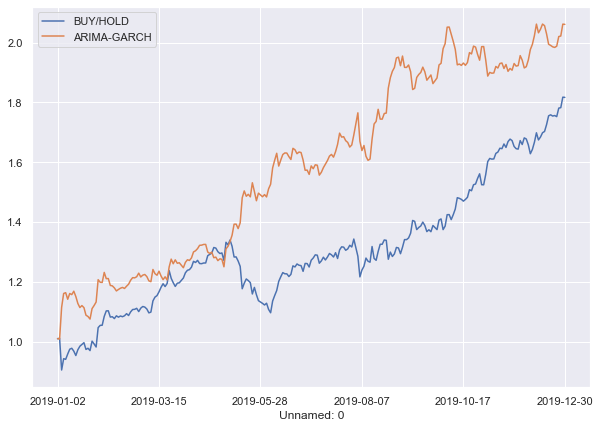

In [76]:
# Plotting the results of both strategy in the graph
dfcompare.plot()

In [80]:
print("Cumulative Return for both strategies: \n" + str(dfcompare.iloc[-1]) )

Cumulative Return for both strategies: 
BUY/HOLD       1.817069
ARIMA-GARCH    2.061417
Name: 2019-12-30, dtype: float64


Here for bactesting we didn't consider the  slippage, commisions and the dynamic nature of the stock market. If we test this strategy in proper backtesting medium, the return would a bit less then here. 